# Predicting house prices using k-nearest neighbors regression

  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [6]:
import graphlab

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [7]:
sales = graphlab.SFrame('kc_house_data_small.gl/')

# Import useful functions from previous notebooks

To efficiently compute pairwise distances among data points, we will convert the SFrame into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [8]:
import numpy as np # note this allows us to refer to numpy as np instead

In [9]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]  
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe['price'] 
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [10]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features= feature_matrix/norms
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [11]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays:

In [12]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.


In [13]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [20]:
query_house = features_test[0]#first house in test set
query_house.shape[0]

18

Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional vector with components between 0 and 1.

In [21]:
tenth_train_house= features_train[9]
tenth_train_house

array([ 0.01345102,  0.01163464,  0.00602491,  0.0083488 ,  0.00050756,
        0.01279425,  0.        ,  0.        ,  0.01938684,  0.01390535,
        0.0096309 ,  0.        ,  0.01302544,  0.        ,  0.01346821,
       -0.01346254,  0.01195898,  0.00156612])

In [22]:
def Calculate_Euclidean_distance (query,target):
    #dist = []
    dist = (query - target)**2
    dist = np.sum(dist)
    dist = (np.sqrt(dist))
    return dist


In [23]:
x = (Calculate_Euclidean_distance (features_test[0],features_train[9]))
print x

0.0597235937167


In [24]:
from scipy.spatial import distance

dst = distance.euclidean(features_test[0],features_train[9])
print dst

0.0597235937167


In [25]:
distances = (features_test[0]-features_train[9])**2
distances = distances.sum(axis=-1)
distances = np.sqrt(distances)
print distances

0.0597235937167


# Compute multiple distances

In [27]:
dist = Calculate_Euclidean_distance(query_house,tenth_train_house)
dist

0.059723593716661257

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.




Among the first 10 training houses, house is the closest to the query house is : 

In [28]:
arr = []
for i in range(10):
    dist =Calculate_Euclidean_distance (features_test[0],features_train[i])
    print "distance from",i+1,"th point is :",dist
    arr.append(dist)
print arr.index(min(arr))  +1# index of closet house +1 
print arr

distance from 1 th point is : 0.060274709173
distance from 2 th point is : 0.0854688114883
distance from 3 th point is : 0.0614994643712
distance from 4 th point is : 0.0534027397882
distance from 5 th point is : 0.0584448406394
distance from 6 th point is : 0.0598792151018
distance from 7 th point is : 0.0546314049726
distance from 8 th point is : 0.0554310832416
distance from 9 th point is : 0.052383627841
distance from 10 th point is : 0.0597235937167
9
[0.0602747091729555, 0.085468811488270832, 0.061499464371202843, 0.053402739788200579, 0.058444840639381393, 0.059879215101840008, 0.054631404972615261, 0.055431083241597921, 0.052383627840972731, 0.059723593716661257]


In [359]:
print np.argsort(arr) # so 2nd house is closest

[8 3 6 7 4 9 5 0 2 1]


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

The subtraction operator (`-`) in Numpy is vectorized as follows:

In [361]:
print features_train[0:3] - features_test[0]

[[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
    2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
   -1.63756198e-04   0.00000000e+00  -1.70072004e-05   1.30577772e-05
   -5.14364795e-03   6.69281453e-04]
 [  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
    7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
   -1.91048898e-04   6.65082271e-02   4.23240653e-05   6.22415897e-06
   -2.89330197e-03   1.47606982e-03]
 [  0.00000000e+00  -7.75642553e-03  -1.20498190e-02  -1.30002801e-02
    1.60518166e-03  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -5.21450589e-03  -8.32384500e-03  -2.48168183e-02
   -3.13866046e-04   0.00000000e+00   4.71047219e-05   1.56530415e-05
    3.72914476e-03   1.64764925e-03]]


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [362]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print results
print results[0] - (features_train[0]-features_test[0])
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - (features_train[1]-features_test[0])
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print results[2] - (features_train[2]-features_test[0])
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
    2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
   -1.63756198e-04   0.00000000e+00  -1.70072004e-05   1.30577772e-05
   -5.14364795e-03   6.69281453e-04]
 [  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
    7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
   -1.91048898e-04   6.65082271e-02   4.23240653e-05   6.22415897e-06
   -2.89330197e-03   1.47606982e-03]
 [  0.00000000e+00  -7.75642553e-03  -1.20498190e-02  -1.30002801e-02
    1.60518166e-03  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -5.21450589e-03  -8.32384500e-03  -2.48168183e-02
   -3.13866046e-04   0.00000000e+00   4.71047219e-05   1.56530415e-05
    3.72914476e-03   1.64764925e-03]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [363]:
print features_train.shape[0]

5527


In [364]:
diff =[]
for i in xrange(features_train.shape[0]):
    dist = features_train[i]-features_test[0]
    diff.append(dist)
    
    # should print 3 vectors of length 18

To test the code above, run the following cell, which should output a value -0.0934339605842:

In [365]:
print diff[-1].sum() # sum of the feature differences between the query and last training house
# should print -0.0934339605842
print (features_train[-1]-features_test[0]).sum()

-0.0934339605842
-0.0934339605842


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [368]:
print np.sum(np.multiply(diff,diff), axis=1)[15] # take sum of squares across each row, and print the 16th sum
print np.sum(np.power(diff,2), axis=1)[15] # take sum of squares across each row, and print the 16th sum

print np.sum(diff[15]**2) # print the sum of squares for the 16th row -- should be same as above

0.00330705902879
0.00330705902879
0.00330705902879


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.



In [369]:
distances=[]
for i in range(features_train.shape[0]):
    distances.append(np.sqrt(np.sum((features_train[i]-features_test[0])**2)))
#print diff_arr 

To test the code above, run the following cell, which should output a value 0.0237082324496:

In [370]:
print distances[100] # Euclidean distance between the query house and the 101th training house
# should print 0.0237082324496

0.0237082324496


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [379]:
features_train.shape[0]

5527

In [386]:
def Calculate_Euclidean_distance_s(query,features_train):
    distances=[]
    
    for i in xrange(5527):
        x= Calculate_Euclidean_distance(query,features_train[i])
        distances.append(x)
    return distances


In [388]:
distances = (Calculate_Euclidean_distance_s(features_test[2],features_train))


print distances.index(min(distances))
#print features_train[382]
print "Closest match i.e. closest distance 1-NN = predicted value for 1-NN: ",output_train[distances.index(min(distances))]

382
Closest match i.e. closest distance 1-NN = predicted value for 1-NN:  249000


## Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.


In [29]:
def partition_insert(k, Dist_Array, distance):
    Dist_Array_indexarr = np.argsort(Dist_Array)
    
    if (distance<Dist_Array[k-1]):
        condition = False
        j=0
        while (j<k and condition==False) :
            if (distance<Dist_Array[j]):
                #print j                
                Dist_Array[j+1:k]= Dist_Array[j:k-1]
                Dist_Array[j]=distance
                condition=True
            else:
                j=j+1
    return Dist_Array             
                    
                
        
        
    

In [30]:
def KClosest_Training_Houses_test(k,Dist_Array):
    Dist2kNN =[]
    Dist2kNN =[]
    for a in range(k):
        #dist =Calculate_Euclidean_distance (query_house,training_houses_feature_matrix[a])
        Dist2kNN.append(Dist_Array[a])
    print "Dist2kNN arr: ",Dist2kNN
    Dist2kNN_indexarr = np.argsort(Dist2kNN)
    print "sorted index arr: ",Dist2kNN_indexarr

    for i in range(k, k+1): 
        print k,Dist2kNN[Dist2kNN_indexarr[k-1]],Dist2kNN_indexarr[k-1]
        dist_temp = Dist_Array[k]
        print dist_temp
        if (dist_temp<Dist2kNN[Dist2kNN_indexarr[k-1]]):
            condition = False
            j=0
            while (j<k and condition==False) :
                if (dist_temp<Dist2kNN[Dist2kNN_indexarr[j]]):
                    Dist2kNN_indexarr[j+1:k]= Dist2kNN_indexarr[j:k-1]
                    Dist2kNN_indexarr[j]=i
                    condition=True
                else:
                    j = j+1              
                

            
    return Dist2kNN_indexarr

In [395]:
def KClosest_Training_Houses_full(k,training_houses_feature_matrix, query_house):
    Dist2kNN =[]
    Dist2kNN_indexarr=[]
    arr_temp=[]
    test_arr =[]
    
    for a in range(training_houses_feature_matrix.shape[0]):
        dist =Calculate_Euclidean_distance (query_house,training_houses_feature_matrix[a])
        Dist2kNN.append(dist)
    test_arr = np.argsort(Dist2kNN)    
    print test_arr[0:k]   
    #print Dist2kNN
        
    for b in range(k):
        arr_temp.append(Dist2kNN[b])        
    
    Dist2kNN_indexarr = np.argsort(arr_temp)
        
    #print Dist2kNN_indexarr
    for i in range(k, training_houses_feature_matrix.shape[0]):
    #for i in range(k, k+3000):
        dist_temp = Calculate_Euclidean_distance(query_house,training_houses_feature_matrix[i])
        #print "dist_temp: ",dist_temp
        #print Dist2kNN[Dist2kNN_indexarr[k-1]]
        #j=0
        if (dist_temp<Dist2kNN[Dist2kNN_indexarr[k-1]]):
            condition = False
            j=0
            while (j<k and condition==False):
                #print "j: ",j , Dist2kNN_indexarr[j]
                #print "after"
                if (dist_temp<Dist2kNN[Dist2kNN_indexarr[j]]):
                    #print "in if"
                    Dist2kNN_indexarr[j+1:k]= Dist2kNN_indexarr[j:k-1]
                    Dist2kNN_indexarr[j]=i
                    condition=True
                    print "final Dist2kNN_indexarr: ",Dist2kNN_indexarr
                else:
                    #print "else"
                    j = j+1                    
                

            
    return Dist2kNN_indexarr

In [396]:
d = KClosest_Training_Houses_full(4,features_train, features_test[2])
print d
print len(d)


[ 382 1149 4087 3142]
final Dist2kNN_indexarr:  [3 0 4 2]
final Dist2kNN_indexarr:  [3 5 0 4]
final Dist2kNN_indexarr:  [6 3 5 0]
final Dist2kNN_indexarr:  [6 8 3 5]
final Dist2kNN_indexarr:  [ 6  8  3 12]
final Dist2kNN_indexarr:  [ 6 15  8  3]
final Dist2kNN_indexarr:  [ 6 18 15  8]
final Dist2kNN_indexarr:  [ 6 18 30 15]
final Dist2kNN_indexarr:  [ 6 18 38 30]
final Dist2kNN_indexarr:  [ 6 18 38 41]
final Dist2kNN_indexarr:  [ 6 18 38 47]
final Dist2kNN_indexarr:  [ 6 77 18 38]
final Dist2kNN_indexarr:  [ 6 88 77 18]
final Dist2kNN_indexarr:  [ 6 88 77 90]
final Dist2kNN_indexarr:  [  6  88 154  77]
final Dist2kNN_indexarr:  [174   6  88 154]
final Dist2kNN_indexarr:  [174   6 302  88]
final Dist2kNN_indexarr:  [174 376   6 302]
final Dist2kNN_indexarr:  [382 174 376   6]
final Dist2kNN_indexarr:  [382 174 585 376]
final Dist2kNN_indexarr:  [382 598 174 585]
final Dist2kNN_indexarr:  [382 598 746 174]
final Dist2kNN_indexarr:  [382 598 976 746]
final Dist2kNN_indexarr:  [ 382 1149  

In [397]:
def KClosest_Training_Houses(k,training_houses_feature_matrix, query_house):
    Dist2kNN =[]
    Dist2kNN_indexarr=[]
    test_arr =[]
    
    for a in range(training_houses_feature_matrix.shape[0]):
        dist =Calculate_Euclidean_distance (query_house,training_houses_feature_matrix[a])
        Dist2kNN.append(dist)
    test_arr = np.argsort(Dist2kNN)    
    Dist2kNN_indexarr = test_arr[0:k]   
    return Dist2kNN_indexarr

In [399]:
d = KClosest_Training_Houses(4,features_train, features_test[2])
print d

[ 382 1149 4087 3142]


## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.


In [31]:
def predict_kNN(k, training_houses_feature_matrix,output,query_house):
    Dist2kNN_indexarr=[]
    Dist2kNN_indexarr =KClosest_Training_Houses(k,training_houses_feature_matrix, query_house)
    #print "Dist2kNN_indexarr: ", Dist2kNN_indexarr
    sum_price=0
    for i in range(len(Dist2kNN_indexarr)):
        #print i
        #print Dist2kNN_indexarr[i]
        sum_price=sum_price+ output_train[Dist2kNN_indexarr[i]]
    average = sum_price/k
    #print sum_price
    return average
    

In [401]:
k=4

knn_predictedprice =(predict_kNN(k, features_train,output_train,features_test[2]))
print knn_predictedprice


413987


Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [402]:
def predict_KNN_array(k, feature_matrix, output_train, query_set):
    set_of_predicted_values=[]
    for query in query_set:
        predictedprice_i = predict_kNN(k, feature_matrix,output_train,query)
        set_of_predicted_values.append(predictedprice_i)
    return set_of_predicted_values
    

In [403]:
query_set = features_test[0:10]
predicted_arr =(predict_KNN_array(10, features_train, output_train, query_set))
predicted_arr

[881300,
 431860,
 460595,
 430200,
 766750,
 667420,
 350032,
 512800,
 484000,
 457235]

In [326]:
ans = np.argsort(predicted_arr)
print ans

[3 9 2 1 6 8 4 5 7 0]


## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

features_train, output_train = get_numpy_data(train, feature_list, 'price')

features_test, output_test = get_numpy_data(test, feature_list, 'price')

features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

(Depending on your computing environment, this computation may take 10-15 minutes.)

In [300]:
query_set= features_valid
out = output_valid 
RSS_arr =[]
for k in range(1,16):
    predict_arr=predict_KNN_array(k, features_train, output_train, query_set)
    RSS = ((out - predict_arr)**2).sum()
    RSS_arr.append(RSS)
print RSS_arr
    

[219225379089433, 172862910213237, 138506894858600, 129022559647650, 125399699384808, 118200704017114, 114003887794764, 111926585931102, 111191254030854, 107256140831229, 106282526152364, 104143273988285, 105206617995431, 103895375803890, 103615179363825]


In [301]:
x = np.argsort(RSS_arr)
print x

[14 13 11 12 10  9  8  7  6  5  4  3  2  1  0]


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

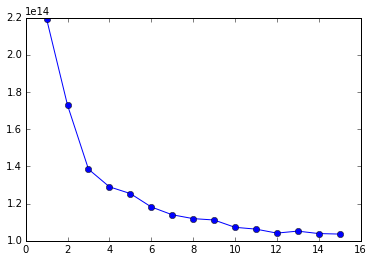

In [302]:
import matplotlib.pyplot as plt
%matplotlib inline
rss_all = RSS_arr
kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')